# Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#設定分割函數

In [5]:
import os
import random
import shutil

def split_dataset(source_folder, train_folder, val_folder, split_ratio=0.8):
  # 設定隨機種子，確保每次結果一致
  random.seed(42)

  # 建立目標資料夾
  os.makedirs(train_folder, exist_ok=True)
  os.makedirs(val_folder, exist_ok=True)

  # 取得所有圖片檔案
  all_images = [f for f in os.listdir(source_folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

  # 打亂順序
  random.shuffle(all_images)

  # 計算分割數量
  split_index = int(len(all_images) * 0.8)
  train_images = all_images[:split_index]
  val_images = all_images[split_index:]

  # 複製圖片到對應資料夾
  for img in train_images:
      shutil.copy(os.path.join(source_folder, img), os.path.join(train_folder, img))

  for img in val_images:
      shutil.copy(os.path.join(source_folder, img), os.path.join(val_folder, img))

  print(f"共處理 {len(all_images)} 張圖片，其中 {len(train_images)} 張放到 train， {len(val_images)} 張放到 val。")

##分割dataset至訓練集和測試集(AI dataset)

In [6]:
s_folder = '/content/drive/MyDrive/dataset/AI'
t_folder = '/content/data/train/fake'
v_folder = '/content/data/val/fake'
split_dataset(source_folder= s_folder,
              train_folder= t_folder,
              val_folder= v_folder)

共處理 537 張圖片，其中 429 張放到 train， 108 張放到 val。


##分割dataset至訓練集和測試集(Real dataset)

In [7]:
s_folder = '/content/drive/MyDrive/dataset/Real'
t_folder = '/content/data/train/real'
v_folder = '/content/data/val/real'
split_dataset(source_folder= s_folder,
              train_folder= t_folder,
              val_folder= v_folder)

共處理 440 張圖片，其中 352 張放到 train， 88 張放到 val。


## 清空資料夾(If needed)

In [8]:
def delete_folder(folder_path):
  # 刪除該資料夾下的所有檔案與子資料夾
  for filename in os.listdir(folder_path):
      file_path = os.path.join(folder_path, filename)
      if os.path.isfile(file_path) or os.path.islink(file_path):
          os.unlink(file_path)  # 刪除檔案或符號連結
      elif os.path.isdir(file_path):
          shutil.rmtree(file_path)  # 刪除子資料夾

  print(f"{folder_path} 資料夾內容已清空。")

delete_folder('/content/data/train/fake')
delete_folder('/content/data/train/real')
delete_folder('/content/data/val/fake')
delete_folder('/content/data/val/real')

/content/data/train/fake 資料夾內容已清空。
/content/data/train/real 資料夾內容已清空。
/content/data/val/fake 資料夾內容已清空。
/content/data/val/real 資料夾內容已清空。


#Excution

In [15]:
# 📌 1. 安裝必要套件（Colab 可用）
!pip install torch torchvision matplotlib

# 📌 2. 匯入模組
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import time

# 📌 3. 設定路徑與參數
data_dir = "/content/data"
batch_size = 32
num_epochs = 6
num_classes = 2  # Real vs AI
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📌 4. 圖片轉換與資料加載器
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}

!find /content/data -type d -name ".ipynb_checkpoints" -exec rm -r {} +
print("✅ 清除 .ipynb_checkpoints 資料夾成功")

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
               for x in ['train', 'val']}

# 📌 5. 載入 ResNet 模型（ResNet-18）
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# 📌 6. 損失與優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 📌 7. 訓練與驗證函式
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print(f"\n🔁 Epoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            running_loss = 0.0
            running_corrects = 0
            model.train() if phase == 'train' else model.eval()
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print(f"{phase.upper()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
    return model

# 📌 8. 開始訓練
trained_model = train_model(model, dataloaders, criterion, optimizer, num_epochs)

✅ 清除 .ipynb_checkpoints 資料夾成功

🔁 Epoch 1/6
TRAIN Loss: 0.5526 Acc: 0.7145
VAL Loss: 0.5140 Acc: 0.7653

🔁 Epoch 2/6
TRAIN Loss: 0.1892 Acc: 0.9321
VAL Loss: 0.4951 Acc: 0.8163

🔁 Epoch 3/6
TRAIN Loss: 0.0996 Acc: 0.9731
VAL Loss: 0.5271 Acc: 0.8214

🔁 Epoch 4/6
TRAIN Loss: 0.0537 Acc: 0.9872
VAL Loss: 0.5451 Acc: 0.8061

🔁 Epoch 5/6
TRAIN Loss: 0.0253 Acc: 0.9962
VAL Loss: 0.6638 Acc: 0.8163

🔁 Epoch 6/6
TRAIN Loss: 0.0176 Acc: 0.9974
VAL Loss: 0.6240 Acc: 0.8163
✅ 模型已儲存


In [28]:
# 📌 9. 儲存模型
torch.save(trained_model.state_dict(), "resnet_ai_detector.pth")
shutil.copy("resnet_ai_detector.pth", "/content/drive/MyDrive/model")
print("✅ 模型已儲存")

# 📌 10. 預測單張圖片
from PIL import Image

def predict_image(image_path, model):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    transform = data_transforms['val']
    input_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)
        class_names = image_datasets['train'].classes
        print(f"✅ 預測結果: {class_names[pred.item()]}")
        plt.imshow(img)
        plt.title(f"Result: {class_names[pred.item()]}")
        plt.axis('off')
        plt.show()


✅ 模型已儲存


<ipython-input-30-361ee7ae4cad>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet_ai_detector.pth", map_location=device))


✅ 預測結果: fake


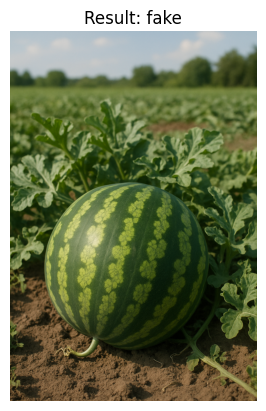

In [30]:
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)  # 和之前保持一致
model.load_state_dict(torch.load("resnet_ai_detector.pth", map_location=device))
model = model.to(device)

predict_image('/content/test/test11.png', model)

# 錯誤樣本收集

In [ ]:
# --- 設定路徑 ---
image_folder = '/content/drive/MyDrive/my_new_dataset/Fake'  # 原始圖片資料夾
wrong_folder = '/content/drive/MyDrive/my_new_dataset/wrongly_classified'  # 放錯誤分類圖片

# --- 創建錯誤分類資料夾 ---
os.makedirs(wrong_folder, exist_ok=True)

# --- 圖像預處理要和訓練時一致 ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 根據你的模型設計修改
    transforms.ToTensor(),
])

# --- 載入模型 ---
model = models.resnet18(pretrained=False)  # 替換為你的模型類別
model.load_state_dict(torch.load('/content/drive/MyDrive/model/resnet_model.pth'))
model.eval().cuda()  # 若有 GPU

# --- 推論 ---
with torch.no_grad():
    for filename in os.listdir(image_folder):
        if not filename.lower().endswith(('.jpg', '.png', '.jpeg')): continue

        image_path = os.path.join(image_folder, filename)
        image = Image.open(image_path).convert('RGB')
        input_tensor = transform(image).unsqueeze(0).cuda()

        output = model(input_tensor)
        pred_class = torch.argmax(output, dim=1).item()

        # --- 這裡依照檔名判斷真實標籤 ---
        if filename.lower().startswith("real"):
            label = 0
        elif filename.lower().startswith("fake"):
            label = 1
        else:
            print(f"無法判斷標籤: {filename}")
            continue

        # --- 判斷錯誤就複製圖片過去 ---
        if pred_class != label:
            shutil.copy(image_path, os.path.join(wrong_folder, filename))
            print(f"[錯誤分類] 已移動: {filename}")
